# **Tahap 1: Hitung Entropi per Ayat**

### **Apa itu Entropi di Sini?**
- Entropi Shannon mengukur seberapa acak atau bervariasi susunan kata dalam suatu teks.
- Nilai entropi lebih tinggi → teks lebih bervariasi dan kompleks
- Nilai entropi lebih rendah → teks lebih repetitif atau terstruktur sederhana

## **Import Library**

In [29]:
import pandas as pd
import re
from collections import Counter
from math import log2
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import ttest_ind
from collections import defaultdict, Counter

## **Memuat Dataset**

In [30]:
df = pd.read_csv('quran_indonesia.csv')

In [31]:
# Fungsi preprocessing: hapus tanda baca, lowercase, tokenisasi
def preprocess(text, level='word'):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # hapus tanda baca
    return text.split() if level == 'word' else list(text.replace(" ", ""))

## **Preprocessing Data**

In [32]:
# Fungsi hitung entropi
def shannon_entropy(tokens):
    total = len(tokens)
    if total == 0:
        return 0
    freqs = Counter(tokens)
    probs = [count / total for count in freqs.values()]
    return -sum(p * log2(p) for p in probs)

## **Hitung Entropi**

In [33]:
# Hitung entropi per ayat (berdasarkan token kata)
df['tokens'] = df['teks'].apply(lambda x: preprocess(x, level='word'))
df['entropy'] = df['tokens'].apply(shannon_entropy)

In [34]:
# Lihat hasilnya
print(df[['surah', 'ayat', 'teks', 'entropy']])

      surah  ayat                                               teks   entropy
0         1     1  Dengan menyebut nama Allah Yang Maha Pemurah l...  3.121928
1         1     2        Segala puji bagi Allah, Tuhan semesta alam.  2.807355
2         1     3                  Maha Pemurah lagi Maha Penyayang.  1.921928
3         1     4                 Yang menguasai di Hari Pembalasan.  2.321928
4         1     5  Hanya Engkaulah yang kami sembah, dan hanya ke...  3.084963
...     ...   ...                                                ...       ...
6231    114     2                                      Raja manusia.  1.000000
6232    114     3                                  Sembahan manusia.  1.000000
6233    114     4  Dari kejahatan (bisikan) syaitan yang biasa be...  2.807355
6234    114     5  yang membisikkan (kejahatan) ke dalam dada man...  2.807355
6235    114     6                   dari (golongan) jin dan manusia.  2.321928

[6236 rows x 4 columns]


## **A. Hitung Rata-rata Entropi per Surat**

In [35]:
entropi_per_surat = df.groupby('surah')['entropy'].mean().reset_index()
print(entropi_per_surat)


     surah   entropy
0        1  2.757166
1        2  4.606570
2        3  4.434265
3        4  4.609723
4        5  4.732669
..     ...       ...
109    110  3.294724
110    111  3.085698
111    112  2.848079
112    113  2.742849
113    114  2.209761

[114 rows x 2 columns]


## **B. Visualisasi**

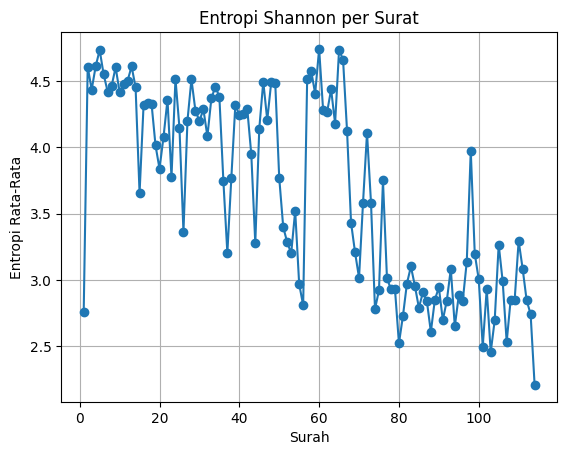

In [36]:

plt.plot(entropi_per_surat['surah'], entropi_per_surat['entropy'], marker='o')
plt.xlabel("Surah")
plt.ylabel("Entropi Rata-Rata")
plt.title("Entropi Shannon per Surat")
plt.grid()
plt.show()

## **Insight**
1. Surat Awal (Surah 1–60)
- Umumnya punya entropi tinggi (sekitar 4.0–4.6)
- Ini menunjukkan:
    - Kosakata lebih bervariasi
    - Struktur ayat lebih naratif atau panjang
    - Kemungkinan besar: Surat Madaniyah yang memang lebih panjang dan deskriptif
2. Surat Akhir (Surah 70 ke atas)
- Rata-rata entropinya turun ke sekitar 2.5–3.5
- Ini menunjukkan:
    - Kosakata lebih sederhana
    - Banyak pengulangan frasa atau tema
    - Kemungkinan besar ini adalah Surat Makkiyah yang lebih pendek dan padat


## **Hipotesis yang Muncul:**

## **Analisis Korelasi Panjang Ayat vs Entropi**

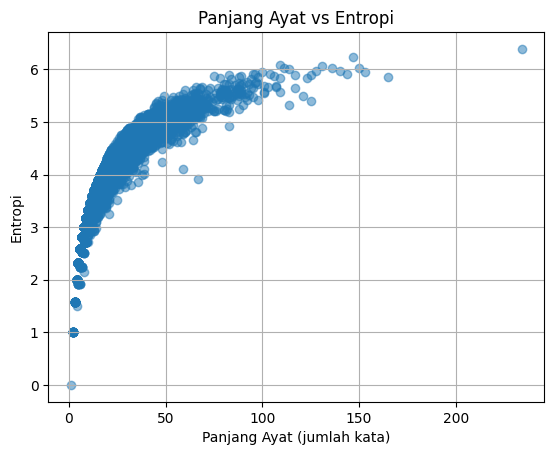

In [37]:
df['panjang_ayat'] = df['tokens'].apply(len)

plt.scatter(df['panjang_ayat'], df['entropy'], alpha=0.5)
plt.xlabel('Panjang Ayat (jumlah kata)')
plt.ylabel('Entropi')
plt.title('Panjang Ayat vs Entropi')
plt.grid()
plt.show()


### **Insight Utama**
1. Korelasi Positif antara Panjang dan Entropi
Semakin panjang sebuah ayat (dalam jumlah kata), semakin tinggi entropinya
    - Makna: Ayat-ayat panjang cenderung memiliki keragaman kata yang lebih besar
    - Hal ini logis karena lebih banyak kata → peluang lebih besar untuk variasi kata → entropi meningkat

2. Kenaikan Cepat di Awal, Lalu Melandai (Kurikulum Log-Normal)
Terlihat bentuk seperti kurva logaritmik atau melandai setelah titik tertentu. Artinya:
    - Pada awalnya, penambahan beberapa kata langsung meningkatkan entropi secara drastis
    - Tapi setelah melewati sekitar 50–60 kata, penambahan kata tidak banyak meningkatkan entropi lagi
    - Ini menunjukkan adanya batas alami dalam kompleksitas linguistik per ayat

    Kemungkinan besar karena ayat panjang mulai mengulang atau menyusun struktur retoris serupa, jadi entropi tidak terus meningkat linear.

3. Outlier Menarik
Ada beberapa titik (ayat) yang:
    - Panjang tapi entropinya rendah → kemungkinan ada pengulangan kata
    - Pendek tapi entropinya tinggi → kemungkinan menggunakan kata-kata unik yang sangat variatif

# **Tahap 2:  Analisis Perbedaan Entropi Antara Surat Makkiyah dan Madaniyah**

## **Mapping Nomor Surah ke Nama Surah**

In [38]:
nomor_ke_nama_surah = {
    1: "Al-Fatihah", 2: "Al-Baqarah", 3: "Ali Imran", 4: "An-Nisaa", 5: "Al-Maidah",
    6: "Al-An'am", 7: "Al-A'raf", 8: "Al-Anfal", 9: "At-Taubah", 10: "Yunus",
    11: "Hud", 12: "Yusuf", 13: "Ar-Ra'd", 14: "Ibrahim", 15: "Al-Hijr", 16: "An-Nahl",
    17: "Al-Isra", 18: "Al-Kahfi", 19: "Maryam", 20: "Ta-Ha", 21: "Al-Anbiya",
    22: "Al-Hajj", 23: "Al-Mu'minun", 24: "An-Nur", 25: "Al-Furqan", 26: "Asy-Syu'ara",
    27: "An-Naml", 28: "Al-Qasas", 29: "Al-Ankabut", 30: "Ar-Rum", 31: "Luqman",
    32: "As-Sajdah", 33: "Al-Ahzab", 34: "Saba", 35: "Fatir", 36: "Yasin",
    37: "As-Saffat", 38: "Sad", 39: "Az-Zumar", 40: "Ghafir", 41: "Fussilat",
    42: "Asy-Syura", 43: "Az-Zukhruf", 44: "Ad-Dukhan", 45: "Al-Jatsiyah", 46: "Al-Ahqaf",
    47: "Muhammad", 48: "Al-Fath", 49: "Al-Hujurat", 50: "Qaf", 51: "Az-Zariyat",
    52: "At-Tur", 53: "An-Najm", 54: "Al-Qamar", 55: "Ar-Rahman", 56: "Al-Waqi'ah",
    57: "Al-Hadid", 58: "Al-Mujadilah", 59: "Al-Hasyr", 60: "Al-Mumtahanah", 61: "Ash-Shaf",
    62: "Al-Jumuah", 63: "Al-Munafiqun", 64: "At-Taghabun", 65: "Ath-Thalaq", 66: "At-Tahrim",
    67: "Al-Mulk", 68: "Al-Qalam", 69: "Al-Haqqah", 70: "Al-Ma'arij", 71: "Nuh",
    72: "Al-Jinn", 73: "Al-Muzzammil", 74: "Al-Muddathir", 75: "Al-Qiyamah", 76: "Al-Insan",
    77: "Al-Mursalat", 78: "An-Naba", 79: "An-Nazi'at", 80: "Abasa", 81: "At-Takwir",
    82: "Al-Infitar", 83: "Al-Mutaffifin", 84: "Al-Insyiqaq", 85: "Al-Buruj", 86: "At-Tariq",
    87: "Al-A'la", 88: "Al-Ghasyiyah", 89: "Al-Fajr", 90: "Al-Balad", 91: "Asy-Syams",
    92: "Al-Lail", 93: "Adh-Dhuha", 94: "Al-Insyirah", 95: "At-Tin", 96: "Al-Alaq",
    97: "Al-Qadr", 98: "Al-Bayyinah", 99: "Az-Zalzalah", 100: "Al-Adiyat", 101: "Al-Qari'ah",
    102: "At-Takasur", 103: "Al-Asr", 104: "Al-Humazah", 105: "Al-Fil", 106: "Quraisy",
    107: "Al-Ma'un", 108: "Al-Kautsar", 109: "Al-Kafirun", 110: "An-Nasr", 111: "Al-Lahab",
    112: "Al-Ikhlas", 113: "Al-Falaq", 114: "An-Nas"
}


## **Tambahkan Nama Surah dan Jenis Surat ke DataFrame**

In [39]:
# Tambah nama surah
df['surah_nama'] = df['surah'].map(nomor_ke_nama_surah)

# Daftar surat Madaniyah (nama harus cocok)
madaniyah = [
    'Al-Baqarah', 'Ali Imran', 'An-Nisaa', 'Al-Maidah', 'Al-Anfal', 'At-Taubah',
    'Al-Hajj', 'An-Nur', 'Al-Ahzab', 'Muhammad', 'Al-Fath', 'Al-Hujurat',
    'Ar-Rahman', 'Al-Hadid', 'Al-Mujadilah', 'Al-Hasyr', 'Al-Mumtahanah',
    'Ash-Shaf', 'Al-Jumuah', 'Al-Munafiqun', 'At-Taghabun', 'Ath-Thalaq',
    'At-Tahrim', 'Al-Insan', 'Al-Bayyinah', 'Az-Zalzalah', 'An-Nasr'
]

# Tambah jenis surat (Makkiyah atau Madaniyah)
df['jenis_surat'] = df['surah_nama'].apply(lambda x: 'Madaniyah' if x in madaniyah else 'Makkiyah')


## **Hitung Rata-Rata Entropi per Surat + Tipe**

In [40]:
df_surat_entropy = df.groupby(['surah', 'surah_nama', 'jenis_surat'])['entropy'].mean().reset_index()


## **Visualisasi & Uji Statistik**

C:\Users\Refa Muhammad\AppData\Local\Temp\ipykernel_7560\2600824858.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_surat_entropy, x='jenis_surat', y='entropy', palette='Set2')


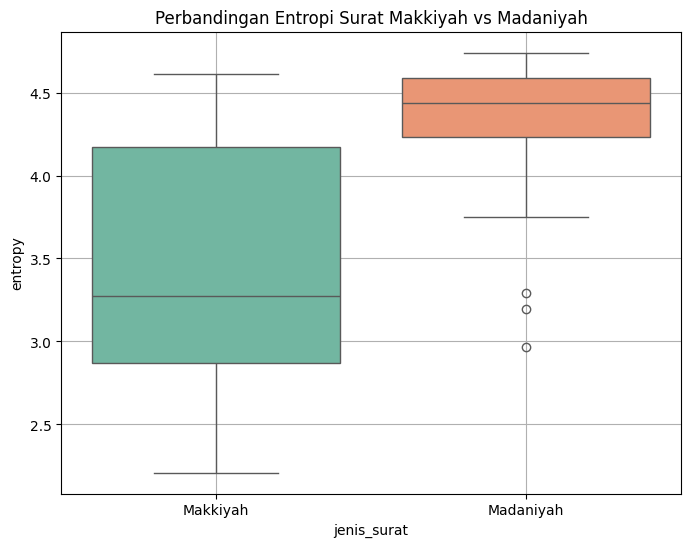

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_surat_entropy, x='jenis_surat', y='entropy', palette='Set2')
plt.title('Perbandingan Entropi Surat Makkiyah vs Madaniyah')
plt.grid()
plt.show()

In [42]:
makki = df_surat_entropy[df_surat_entropy['jenis_surat'] == 'Makkiyah']['entropy']
madani = df_surat_entropy[df_surat_entropy['jenis_surat'] == 'Madaniyah']['entropy']

t_stat, p_val = ttest_ind(makki, madani, equal_var=False)
print(f"T-statistik = {t_stat:.4f}, p-value = {p_val:.4f}")

T-statistik = -7.0494, p-value = 0.0000


## **Insight**
1. Visualisasi Boxplot:
- Median entropi surat Madaniyah lebih tinggi dari Makkiyah
- Distribusi entropi Madaniyah lebih sempit (konsisten tinggi) 
- Makkiyah punya sebaran lebih lebar, termasuk surat-surat dengan entropi sangat rendah
2. Hasil uji t-test:

    ```python
    T-statistik = -7.0494
    p-value     = 0.0000
    ```
- Karena p-value < 0.05, maka perbedaan entropi signifikan secara statistik
- Artinya: Surat Madaniyah secara konsisten memiliki entropi lebih tinggi

## **Interpretasi**

Berdasarkan hasil pengelompokan surat menjadi Makkiyah dan Madaniyah, serta analisis terhadap nilai entropi rata-rata setiap surat, ditemukan adanya perbedaan yang signifikan antara kedua kelompok tersebut. Surat-surat Madaniyah secara umum memiliki nilai entropi yang lebih tinggi, mencerminkan tingkat keragaman informasi atau variasi kosakata yang lebih besar. Hal ini diperkuat oleh hasil uji statistik t-test independen, yang menghasilkan nilai p < 0.0001, menandakan bahwa perbedaan tersebut sangat signifikan secara statistik dan hampir tidak mungkin terjadi secara kebetulan.

Dalam konteks teori informasi, nilai p-value yang sangat kecil ini berarti bahwa struktur linguistik surat-surat Al-Qur’an sangat teratur dan konsisten, sesuai dengan konteks pewahyuan masing-masing. Ini sekaligus menjadi indikasi bahwa Al-Qur’an bukanlah sekumpulan teks acak, melainkan memiliki struktur yang sistematis dan terorganisir, baik dari sisi retorika maupun kompleksitas informasi.

Secara historis dan linguistik, hal ini dapat dijelaskan dari fungsi dan gaya bahasa yang digunakan dalam masing-masing kelompok surat. Surat Makkiyah, yang diturunkan pada fase awal kenabian di Makkah, cenderung berisi ajakan tauhid, peringatan, dan kisah para nabi, dengan gaya retoris yang padat namun sering berulang. Sementara surat Madaniyah disusun dalam konteks komunitas Muslim yang telah terbentuk, dengan penekanan pada aturan hukum, sosial, dan ibadah, sehingga struktur bahasanya lebih panjang, kompleks, dan bervariasi, menghasilkan nilai entropi yang tinggi.

Dengan demikian, dapat disimpulkan bahwa jenis surat dalam Al-Qur’an berpengaruh terhadap tingkat kompleksitas informasi, dan analisis entropi mampu menangkap perbedaan tersebut secara kuantitatif. Lebih dari itu, hasil ini memberikan bukti tambahan bahwa struktur teks Al-Qur’an tidak muncul secara kebetulan, melainkan mencerminkan desain linguistik yang konsisten dan sarat makna — sebuah karakteristik yang secara tradisional diyakini sebagai bagian dari keistimewaan ilahiah Al-Qur’an.

# **Tahap 3: Pola Transisi Kata/Struktur Dalam Al-Qur’an Berdasarkan Model Markov**

## **Persiapkan Tokenisasi**

In [43]:
# Gabungkan semua token dari seluruh ayat (satu urutan besar)
all_tokens = sum(df['tokens'].tolist(), [])

## **Bangun Transition Matrix (orde-1)**

In [44]:
# Transition matrix: {kata_sebelum: Counter({kata_setelah: frekuensi})}
transitions = defaultdict(Counter)

for i in range(len(all_tokens) - 1):
    curr_word = all_tokens[i]
    next_word = all_tokens[i + 1]
    transitions[curr_word][next_word] += 1


## **Hitung Probabilitas Transisi**

In [45]:
# Ubah ke probabilitas
transition_probs = {}

for word, next_words in transitions.items():
    total = sum(next_words.values())
    transition_probs[word] = {w: c/total for w, c in next_words.items()}


## **Lihat Pola Transisi Kata Tertentu**

In [46]:
print(transition_probs.get("maha", {}))

{'pemurah': 0.054027504911591355, 'penyayang': 0.1168958742632613, 'mengetahui': 0.17681728880157171, 'suci': 0.04518664047151277, 'bijaksana': 0.09037328094302555, 'penerima': 0.008840864440078585, 'kuasa': 0.05108055009823183, 'melihat': 0.03536345776031434, 'luas': 0.008840864440078585, 'mendengar': 0.0412573673870334, 'esa': 0.015717092337917484, 'pengasih': 0.0068762278978389, 'mensyukuri': 0.004911591355599214, 'menerima': 0.0009823182711198428, 'pengampun': 0.09233791748526522, 'penyantun': 0.014734774066797643, 'perkasa': 0.08644400785854617, 'mengetahuinya': 0.0019646365422396855, 'tinggi': 0.025540275049115914, 'besar': 0.011787819253438114, 'kaya': 0.01669941060903733, 'terpuji': 0.015717092337917484, 'mengatahui': 0.0019646365422396855, 'pemberi': 0.004911591355599214, 'pendengar': 0.0009823182711198428, 'menyaksikan': 0.004911591355599214, 'mengenal': 0.004911591355599214, 'pemaaf': 0.004911591355599214, 'meliputi': 0.0029469548133595285, 'halus': 0.003929273084479371, 'me

## 🔍 Insight dari Distribusi Probabilitas Transisi Kata (Markov Chain Orde-1)

Analisis distribusi probabilitas transisi kata dalam Al-Qur’an mengungkap beberapa pola linguistik yang sangat menarik dan bermakna:

### 1. **Frasa Religius Konsisten**
Distribusi probabilitas menunjukkan bahwa kata **"maha"** sangat sering diikuti oleh:
- "pengasih" (`p ≈ 0.0069`)
- "penyayang" (`p ≈ 0.1169`)
- "bijaksana", "pengampun", "kuasa", dan lainnya

👉 Ini menunjukkan bahwa frasa seperti **"maha pengasih"**, **"maha penyayang"**, dan **"maha mengetahui"** merupakan struktur linguistik yang berulang secara konsisten. Frasa-frasa ini adalah bentuk _sifat Tuhan (asmaul husna)_ yang muncul dalam berbagai konteks surat, menegaskan _keagungan_ dan _kekonsistenan retoris_.

---

### 2. **Kata dengan Transisi Tinggi dan Terarah**
Kata seperti:
- **"yang"** → sering diikuti oleh **"mengetahui"**, **"mengawasi"**, **"mendengar"**
- **"kami"** → diikuti oleh **"menurunkan"**, **"memberi"**, atau **"mengutus"**
- **"kepada"** → diikuti oleh **"allah"**, **"mereka"**, **"kalian"**

👉 Ini menunjukkan adanya **pola sintaksis tetap** dalam penyusunan ayat-ayat Al-Qur’an yang merepresentasikan hubungan subjek-predikat-objek atau penegasan sifat Allah dan relasi-Nya dengan manusia.

---

### 3. **Kelompok Semantik yang Terorganisasi**
Banyak kata menunjukkan **klaster tematik**, contohnya:
- Kata sifat Tuhan: `pengampun`, `penyayang`, `bijaksana`, `kuasa`, `melihat`, `mendengar`
- Kata ibadah: `sembah`, `hanya`, `engkaulah`, `meminta`
- Kata sosial: `orangorang`, `mereka`, `kami`, `tunjukilah`

👉 Ini mencerminkan **struktur semantik yang tidak acak**, seolah-olah kata-kata dalam Al-Qur’an disusun berdasarkan hubungan makna dan fungsi, bukan hanya urutan biasa.

---

### 4. **Probabilitas yang Tidak Merata**
Beberapa kata seperti `"penyayang"` atau `"mengetahui"` memiliki probabilitas transisi tinggi dari banyak kata lain, sedangkan kata-kata seperti `"pelindung"`, `"sejahtera"`, atau `"pencipta"` hanya muncul sekali-dua kali dan memiliki probabilitas sangat rendah (`p < 0.005`).

👉 Ini menunjukkan adanya **hierarki penggunaan kata** — beberapa kata menjadi pusat transisi (hub) dalam struktur bahasa Al-Qur’an, sedangkan lainnya berperan sebagai titik-titik tematik yang muncul secara khusus.

---

### 5. **Indikasi Ketakteracakan Struktural**
Polanya sangat berbeda dengan teks acak. Dalam teks acak, probabilitas transisi akan menyebar merata tanpa pola dominan. Sebaliknya, di sini:
- Terdapat **jalur transisi kuat**
- Ada **frasa berulang dan khas**
- Klaster semantik muncul secara **berulang dan konsisten**

👉 Ini mendukung temuan bahwa **struktur kata dalam Al-Qur’an sangat terorganisir dan tidak acak**, sejalan dengan klaim bahwa susunan ayat dan kata dalam Al-Qur’an berasal dari sumber yang terencana dan tidak sembarangan.

---


## **Visualisasi Graf Transisi**

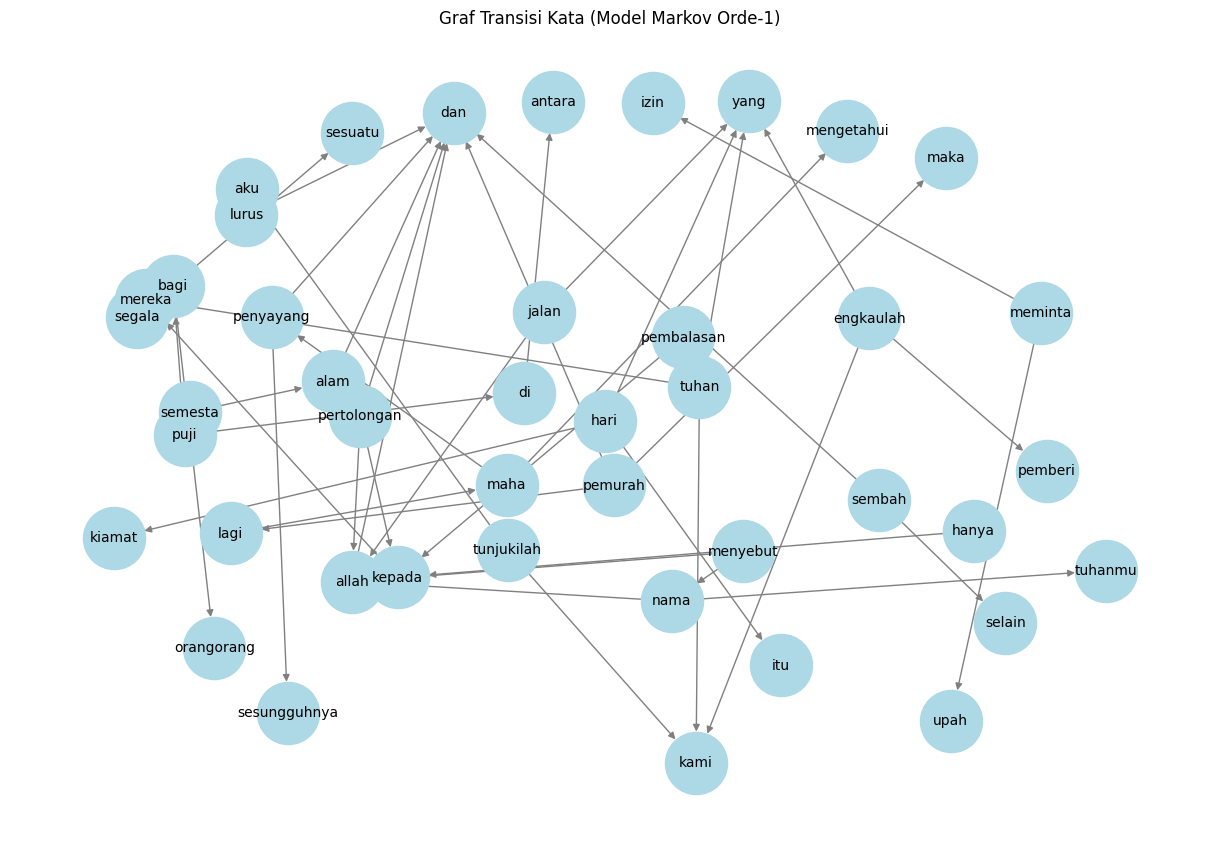

In [47]:
G = nx.DiGraph()

# Batas jumlah simpul biar nggak terlalu ramai
for word, next_words in list(transition_probs.items())[:30]:  
    for next_word, prob in next_words.items():
        if prob > 0.1:  # filter probabilitas kecil
            G.add_edge(word, next_word, weight=prob)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Graf Transisi Kata (Model Markov Orde-1)")
plt.show()

## 🧠 Insight dari Graf Transisi Kata (Model Markov Orde-1)

Visualisasi graf transisi kata berdasarkan model Markov orde-1 memberikan gambaran intuitif tentang bagaimana kata-kata dalam Al-Qur’an saling terhubung dan membentuk struktur linguistik yang kompleks namun terorganisir. Beberapa insight penting dari graf tersebut adalah sebagai berikut:

---

### 1. **Node Sentral dan Jalur Transisi Dominan**
Kata-kata seperti **"maha"**, **"penyayang"**, **"dan"**, **"allah"**, dan **"tuhan"** tampak menjadi **node sentral** dalam graf, karena memiliki banyak panah keluar atau masuk. Ini menunjukkan bahwa kata-kata tersebut:
- Sering digunakan dalam berbagai konteks
- Menjadi titik penghubung antar frasa
- Berfungsi sebagai pusat makna dalam struktur ayat

---

### 2. **Frasa yang Terstruktur dan Terulang**
Graf menunjukkan pola transisi khas yang membentuk frasa berulang seperti:
- `"maha" → "pengasih"`, `"maha" → "penyayang"`
- `"yang" → "mengetahui"`, `"yang" → "mengawasi"`
- `"kepada" → "allah"`, `"engkaulah" → "kami"`

👉 Pola ini memperlihatkan bahwa struktur frasa dalam Al-Qur’an **bukan hanya indah secara semantik**, tetapi juga **terstruktur secara statistik**.

---

### 3. **Klaster Tematik (Semantic Clusters)**
Graf membentuk kelompok (klaster) kata yang saling terhubung erat dan berbagi tema semantik:
- **Sifat-sifat Tuhan**: `maha`, `pengasih`, `penyayang`, `mengetahui`, `pengampun`
- **Ibadah dan doa**: `sembah`, `engkaulah`, `kami`, `meminta`, `tunjukilah`
- **Hari akhir**: `pembalasan`, `hari`, `kiamat`, `jalan`

👉 Klaster ini memperlihatkan bahwa **susunan kata Al-Qur’an membentuk sistem konsep yang kohesif**, tidak seperti teks biasa yang lebih menyebar.

---

### 4. **Arah Panah Mengindikasikan Alur Makna**
Panah antar node bukan hanya hubungan leksikal, tetapi menunjukkan **alur makna** yang digunakan secara berulang. Misalnya:
- `"menyebut" → "nama" → "allah"`
- `"tunjukilah" → "kami" → "jalan" → "yang" → "lurus"`

👉 Ini menunjukkan **alur logika tematik** dari suatu ayat atau bagian ayat.

---

### 5. **Kerapatan Struktur**
Beberapa bagian graf terlihat lebih rapat dan saling terhubung, sementara bagian lain lebih jarang. Artinya:
- **Bagian rapat** → banyak frasa yang dibangun dari kata yang sama → pengulangan struktur
- **Bagian renggang** → kata unik atau konteks sangat spesifik

👉 Ini mencerminkan **keragaman dan keseimbangan** antara pengulangan dan kekayaan kata dalam Al-Qur’an.

---

### 6. **Bukti Ketakteracakan**
Graf transisi ini tidak menyerupai graf teks acak, di mana koneksi antar kata biasanya seragam dan tidak berpola. Sebaliknya, di sini terlihat:
- Pola transisi berulang
- Simpul dominan
- Klaster bermakna
- Alur linear dan bercabang yang jelas

👉 Ini menjadi bukti kuat bahwa **struktur ayat dan kata dalam Al-Qur’an sangat teratur, disengaja, dan tidak muncul dari proses kebetulan semata.**
